This is a TensorFlow implementation of the Collaborative Filtering recommender system

In [1]:
import scipy.io
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
import numpy as np
import math

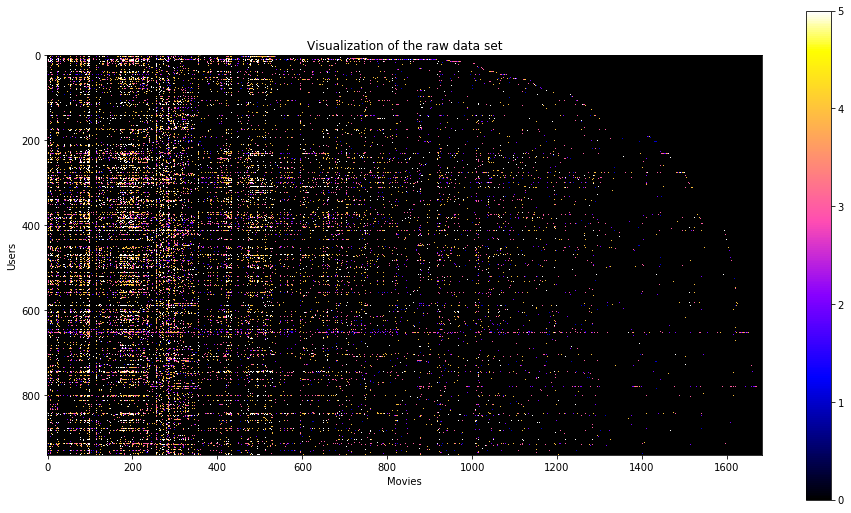

In [2]:
mat = scipy.io.loadmat('movies_data.mat')
R = mat['R'].astype(float)
Y = mat['Y'].astype(float)
num_m = R.shape[0]
num_u = R.shape[1]
titles = open('movie_ids.txt','r')
titles = titles.readlines()
clean_titles = [titles[i].replace('\n','') for i in range(num_m)]
clean_titles = np.array(clean_titles)

data = {'Y':Y, 'R':R, 'clean_titles':clean_titles}
np.save('processed_data', data)

s = 100
x = num_m/s
y = num_u/s
fig = plt.figure(figsize=(x,y))
plt.imshow(np.transpose(Y), cmap='gnuplot2')
plt.title('Visualization of the raw data set')
plt.xlabel('Movies')
plt.ylabel('Users')
plt.colorbar()
plt.show();

#### Apparently, the raters got tired as they approached the bottom of the list. :)

In [3]:
print 'Number of movies = ',len(titles),'= Y.shape[0], and the number of users is', Y.shape[1]

Number of movies =  1682 = Y.shape[0], and the number of users is 943


In [4]:
def avg(i,rc):
    # average rating of column i of Y for the nonzero entries
    # rc = 'r' for rows and 'c' for columns
    if rc == 'r':
        return np.average(Y[i,:][R[i,:]!=0])
    elif rc == 'c':
        return np.average(Y[:,i][R[:,i]!=0])

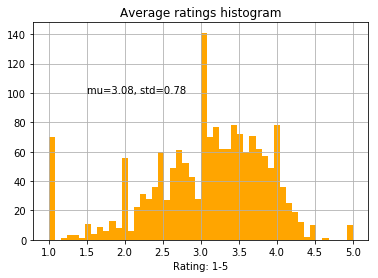

In [5]:
Avg_m = [avg(j,'r') for j in range(num_m)]

mu = np.average(Avg_m)
sig = np.std(Avg_m)
plt.hist(Avg_m, 50, color='orange')
plt.text(1.5,100,'mu='+str(round(mu,2))+', std='+str(round(sig,2)))
plt.title('Average ratings histogram')
plt.grid(True)
plt.xlabel('Rating: 1-5')
plt.show();

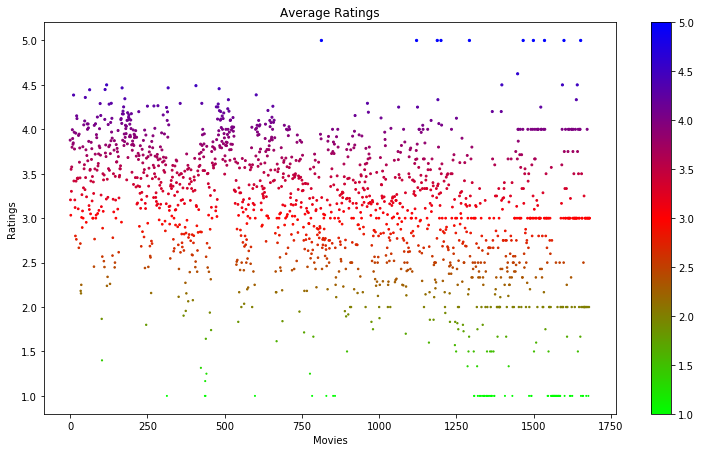

In [6]:
fig = plt.figure(figsize=(x*0.8,y*0.8))
plt.scatter(range(num_m), Avg_m, c=Avg_m, s=Avg_m, alpha=1, cmap='brg_r')
plt.colorbar()
plt.title('Average Ratings')
plt.xlabel('Movies')
plt.ylabel('Ratings')
plt.show();

In [7]:
def filter_movies(m,M):
    # print the names of the movies with m <= rating <= M
    ind = []
    for i in range(num_m):
        if Avg_m[i] >= m and Avg_m[i] <= M:
            ind.append(i)
    return clean_titles[ind]

In [8]:
# the list of movies with ratings in a given interval
filter_movies(4.1,4.2)

array(['22 Braveheart (1995)', '23 Taxi Driver (1976)',
       '89 Blade Runner (1982)', '100 Fargo (1996)',
       '113 Horseman on the Roof, The (Hussard sur le toit, Le) (1995)',
       '136 Mr. Smith Goes to Washington (1939)',
       '165 Jean de Florette (1986)',
       '166 Manon of the Spring (Manon des sources) (1986)',
       '170 Cinema Paradiso (1988)', '173 Princess Bride, The (1987)',
       '185 Psycho (1960)', '187 Godfather: Part II, The (1974)',
       '189 Grand Day Out, A (1992)', '190 Henry V (1989)',
       '191 Amadeus (1984)', '192 Raging Bull (1980)',
       '197 Graduate, The (1967)',
       '199 Bridge on the River Kwai, The (1957)',
       '223 Sling Blade (1996)', '302 L.A. Confidential (1997)',
       '315 Apt Pupil (1998)', '316 As Good As It Gets (1997)',
       '478 Philadelphia Story, The (1940)', '487 Roman Holiday (1953)',
       '488 Sunset Blvd. (1950)', '489 Notorious (1946)',
       '493 Thin Man, The (1934)', "496 It's a Wonderful Life (1946)",


In [10]:
# my_ratings is a vector that saves the inputs of the user
my_ratings = np.zeros((num_m,1))
# remember the indices are shifted by 1: Toy Story is index 0 and so on

my_ratings[10] = 4
my_ratings[49] = 5
my_ratings[55] = 4
my_ratings[70] = 3
my_ratings[63] = 5
my_ratings[81] = 3
my_ratings[95] = 3
my_ratings[126] = 4
my_ratings[133] = 3
my_ratings[187] = 4
my_ratings[297] = 3
my_ratings[312] = 3 
my_ratings[317] = 4

my_R = my_ratings!=0
my_R = my_R.astype(int)

In [11]:
def normal(Y,R, my_ratings):
    '''
    Given the original data matrics Y and R, and the user inputs my_ratings, 
    this returns the normalized augmented Y that contains the user input in 
    column 0
    '''
    my_R = my_ratings!=0
    my_R = my_R.astype(int)
    bigY = np.concatenate((my_ratings, Y), axis=1)
    bigR = np.concatenate((my_R, R), axis=1)
    sumY = np.sum(bigY, axis=1)
    counts = np.sum(bigR, axis=1)
    m = sumY.shape[0]
    avg = np.zeros((m,1))
    for i in range(m):
        avg[i] = sumY[i]/float(counts[i])
    normalY = bigY - avg*bigR
    return normalY, bigR, avg, my_R

In [12]:
# The tensor itself
def create_placeholders(num_m, num_u):
    Y = tf.placeholder(tf.float32, shape = [num_m, num_u], name='Y')
    R = tf.placeholder(tf.float32, shape = [num_m, num_u], name='R')
    return Y, R

def initialize_parameters(num_m, num_u, n=150, seed=1):
    '''
    Initialize the wegights X and Theta
    '''
    X = tf.get_variable('X', [num_m, n], initializer=tf.contrib.layers.xavier_initializer(seed=seed))
    Theta = tf.get_variable('Theta', [num_u, n], initializer=tf.contrib.layers.xavier_initializer(seed=seed))
    
    parameters = {"X": X,
                  "Theta": Theta}
    
    return parameters

tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(20, 10)
    print(parameters['X'])
    print(parameters['Theta'])

def compute_cost(parameters, Y, R, lam):
    '''
    parameters - contains X (weights of the items) and Theta (weights of the users)
    Y - tensor of shape (num_m, num_u) with all ratings
    R - the binary version of Y
    lam - regularization parameters lambda
    
    result is the L_2 norm of the difference between X.Theta^T and Y for nonzero entries of R
    '''
    X = parameters['X']
    Theta = parameters['Theta']
    result = tf.matmul(X,tf.transpose(Theta))
    result = tf.multiply(result,R)
    result = tf.subtract(result, Y)
    result = tf.square(result)
    result = tf.reduce_sum(result)
    regX = tf.multiply(X,X)
    regX = tf.reduce_sum(regX)*lam
    regTheta = tf.multiply(Theta,Theta)
    regTheta = tf.reduce_sum(regTheta)*lam
    return (result+regX+regTheta)/2.    

tf.reset_default_graph()

#####just testing######
with tf.Session() as sess:
    Y_, R_ = create_placeholders(20, 5)
    parameters = initialize_parameters(20, 5)
    c = compute_cost(parameters, Y_, R_,3)
    print("cost = " + str(c))
#######################

def model(Y_train, R_train, lam = 0.05, num_epochs=100, print_int=20, learning_rate=0.009, print_cost=True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (num_m, num_u) = Y_train.shape 
    Y, R = create_placeholders(num_m, num_u)
    parameters = initialize_parameters(num_m, num_u)
    costs = []
    cost = compute_cost(parameters, Y, R, lam)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(0,num_epochs):
            seed += 1
            _, epoch_cost = sess.run([optimizer, cost], feed_dict={Y:Y_train, R:R_train})
            
            if print_cost == True and epoch % print_int == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        return parameters

Tensor("X/read:0", shape=(20, 150), dtype=float32)
Tensor("Theta/read:0", shape=(10, 150), dtype=float32)
cost = Tensor("div:0", shape=(), dtype=float32)


# Approach 1. Prediction on augmented matrices

In [13]:
U = normal(Y,R,my_ratings)

In [14]:
bigY = U[0] # shape = (1682, 944)
bigR = U[1]
avg = U[2]  # avg.shape
my_R = U[3]

Cost after epoch 0: 50041.011719
Cost after epoch 100: 441.833496
Cost after epoch 200: 350.591187
Cost after epoch 300: 324.580658
Cost after epoch 400: 308.856995
Cost after epoch 500: 298.791229
Cost after epoch 600: 291.955444
Cost after epoch 700: 287.073761
Cost after epoch 800: 283.428223
Cost after epoch 900: 280.601990


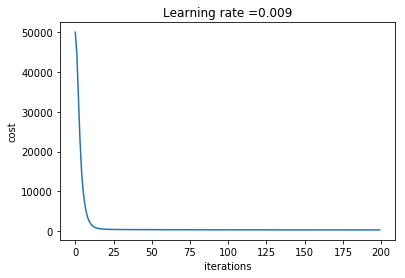

Parameters have been trained!


In [15]:
# lam = 0.05, n = 150
p = model(U[0],U[1], num_epochs=1000,print_int=100)

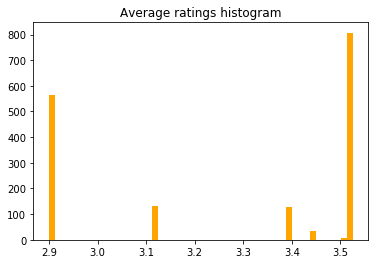

In [16]:
newTheta = p['Theta']
newX = p['X']

Y_pred = np.matmul(newX, np.transpose(newTheta))+avg

my_ratings_pred = Y_pred[:,0]

my_ratings_indices = [i for i, e in enumerate(my_ratings) if e != 0]

remaining_indices = np.delete(my_ratings_pred,my_ratings_indices, axis=0)
remaining_indices = list(remaining_indices)

effective_ratings = np.take(my_ratings_pred, remaining_indices)

plt.hist(effective_ratings, 50, color='orange')
plt.title('Average ratings histogram')
plt.show();

In [17]:
sorted_ratings = sorted(enumerate(effective_ratings), key=lambda x: x[1], reverse=True)

In [18]:
sorted_ratings[0:10]

[(0, 3.5256679889135527),
 (1, 3.5256679889135527),
 (3, 3.5256679889135527),
 (4, 3.5256679889135527),
 (5, 3.5256679889135527),
 (6, 3.5256679889135527),
 (7, 3.5256679889135527),
 (8, 3.5256679889135527),
 (9, 3.5256679889135527),
 (11, 3.5256679889135527)]

In [19]:
for i in range(10):
    print(sorted_ratings[i][0], clean_titles[sorted_ratings[i][0]], round(sorted_ratings[i][1],2))

(0, '1 Toy Story (1995)', 3.53)
(1, '2 GoldenEye (1995)', 3.53)
(3, '4 Get Shorty (1995)', 3.53)
(4, '5 Copycat (1995)', 3.53)
(5, '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 3.53)
(6, '7 Twelve Monkeys (1995)', 3.53)
(7, '8 Babe (1995)', 3.53)
(8, '9 Dead Man Walking (1995)', 3.53)
(9, '10 Richard III (1995)', 3.53)
(11, '12 Usual Suspects, The (1995)', 3.53)


# Approach 2 - Cosine similarity on the original matrix

In [20]:
def normal2(Y,R):
    '''
    Given the original data matrics Y and R, and the user inputs my_ratings, 
    this returns the normalized augmented Y that contains the user input in 
    column 0
    '''
    sumY = np.sum(Y, axis=1)
    counts = np.sum(R, axis=1)
    m = Y.shape[0]
    avg = np.zeros((m,1))
    for i in range(m):
        avg[i] = sumY[i]/float(counts[i])
    normalY = Y - avg*R
    M = np.max(normalY)
    normalY /= M
    return normalY, avg, M

def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity 
    """
    dot = np.dot(u,v)
    norm_u = np.sqrt(np.dot(u,u))
    norm_v = np.sqrt(np.dot(v,v))
    if norm_u*norm_v == 0:
        cosine_similarity = 0
    else:
        cosine_similarity = dot/(norm_u*norm_v)
    
    return cosine_similarity

def top(a,N):
    return list(np.argsort(a)[::-1][:N])

In [21]:
normalY, avg, M = normal2(Y, R)

Cost after epoch 0: 4914.514648
Cost after epoch 100: 104.216324
Cost after epoch 200: 91.127335
Cost after epoch 300: 87.380119


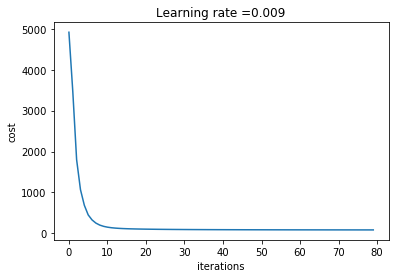

Parameters have been trained!


In [22]:
# lam = 0.05, n = 150
p = model(normalY, R, num_epochs=400,print_int=100)

In [23]:
np.save('parameters', p)

In [24]:
Theta = p['Theta']
X = p['X']

In [25]:
Y_pred = np.matmul(X, np.transpose(Theta))
avg = np.array(Avg_m) # shape = (1682,)
avg = np.reshape(avg, (-1,1))

Y_pred *= M
Y_pred += avg 

#Y_pred[0,0:20]
#Y[0,0:20]

my_ratings = np.zeros((num_m,1))
##########################################
# remember the indices are shifted by 1: Toy Story is index 0 and so on
my_ratings[10] = 4
my_ratings[49] = 5
my_ratings[55] = 4
my_ratings[70] = 3
my_ratings[63] = 5
my_ratings[81] = 3
my_ratings[95] = 3
my_ratings[126] = 4
my_ratings[133] = 3
my_ratings[187] = 4
my_ratings[297] = 3
my_ratings[312] = 3 
my_ratings[317] = 4
###########################################

my_ratings_indices = [i for i, e in enumerate(my_ratings) if e != 0]

Y_pred_slice = Y_pred[my_ratings_indices,:]
Y_orig_slice = Y[my_ratings_indices,:]
Y_slice = Y[my_ratings_indices,:]

my_vec = my_ratings[my_ratings_indices]
my_vec = np.reshape(my_vec, (len(my_vec,)))

#my_ratings_indices
#my_vec

effective_indices = (set(range(num_m))-set(my_ratings_indices))
effective_indices = list(effective_indices)

orig_cosines = [cosine_similarity(my_vec, Y_orig_slice[:,i]) for i in range(num_u)]
pred_cosines = [cosine_similarity(my_vec, Y_pred_slice[:,i]) for i in range(num_u)]

N = 5
closest_users = top(orig_cosines, N)
Z = Y[:, closest_users]
Z = Z[effective_indices, :]

Ratings = np.zeros((Z.shape[0],1))

for i in range(Z.shape[1]):
    Ratings += np.reshape(Z[:,i],((Z.shape[0],1)))/N

Ratings = list(np.transpose(Ratings)[0])

K = 30 # the number top recommended movies
print('Recommendations with projected ratings:')
T = top(Ratings, K)
for i in range(K):
    print(round(Ratings[T[i]],2),clean_titles[T[i]])

Recommendations with projected ratings:
(4.8, '171 Delicatessen (1991)')
(4.8, '9 Dead Man Walking (1995)')
(4.8, '173 Princess Bride, The (1987)')
(4.8, '93 Welcome to the Dollhouse (1995)')
(4.8, '176 Aliens (1986)')
(4.8, '224 Ridicule (1996)')
(4.8, '470 Tombstone (1993)')
(4.6, '462 Like Water For Chocolate (Como agua para chocolate) (1992)')
(4.6, '641 Paths of Glory (1957)')
(4.6, '163 Return of the Pink Panther, The (1974)')
(4.6, '165 Jean de Florette (1986)')
(4.6, '170 Cinema Paradiso (1988)')
(4.6, '174 Raiders of the Lost Ark (1981)')
(4.6, '91 Nightmare Before Christmas, The (1993)')
(4.6, '178 12 Angry Men (1957)')
(4.6, '590 Hellraiser: Bloodline (1996)')
(4.6, '291 Absolute Power (1997)')
(4.6, '8 Babe (1995)')
(4.6, '11 Seven (Se7en) (1995)')
(4.6, '410 Kingpin (1996)')
(4.6, '344 Apostle, The (1997)')
(4.4, '194 Sting, The (1973)')
(4.4, '164 Abyss, The (1989)')
(4.4, '22 Braveheart (1995)')
(4.2, '124 Lone Star (1996)')
(4.2, '172 Empire Strikes Back, The (1980)')
(

In [26]:
param = np.load('parameters.npy')

In [27]:
param

array({'X': array([[ -1.75749391e-01,  -8.36682469e-02,  -5.30128367e-02, ...,
          1.81263819e-01,   1.21182822e-01,  -2.80733909e-02],
       [ -1.67048275e-02,  -1.82793736e-01,  -3.89531516e-02, ...,
         -8.84486083e-03,   9.83169023e-03,  -1.32283401e-02],
       [  6.26400411e-02,   2.55484264e-02,  -3.46551798e-02, ...,
          8.85472819e-02,  -4.12365161e-02,  -1.24131322e-01],
       ..., 
       [  8.14505802e-06,   1.42523622e-05,  -1.24985627e-05, ...,
          5.99901387e-06,  -2.01268667e-05,  -1.03269804e-05],
       [  4.15294853e-05,  -2.95561622e-05,  -4.88091464e-05, ...,
          4.65489284e-05,  -5.31095866e-05,  -4.53178363e-05],
       [  4.88836304e-05,   5.39239481e-05,   5.16861401e-05, ...,
         -4.54202527e-05,   5.62860514e-05,   5.93916411e-05]], dtype=float32), 'Theta': array([[ 0.00500056, -0.13479216, -0.23070635, ...,  0.23588972,
         0.11497514,  0.02566588],
       [-0.08232104,  0.00587737,  0.03449231, ..., -0.04883141,
    

In [28]:
list(clean_titles)

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35